In [10]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
from matplotlib.ticker import FormatStrFormatter
import tables as tb
from pyne import data
import itertools
import re
import os

markers=itertools.cycle(('o','v','s','^','<','>','p','P','*','h','H','+','x','X','D','d','|','_'))

iso_list = ['Xe135', 'Te135','Kr83', 'I135','U235', 'U236', 'U238', 'Pu238','Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Am242', 'H3', 'He4']
colors = matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']

def merge(a,b):
    final = np.zeros (len(a)+len(b))
    for i in range(len(a)):
        final[2*i]   = a[i]
        final[2*i+1] = b[i]
    return final

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

def read_keff_h5(file):
    db = tb.open_file(file, mode='r')
    sim_param = db.root.simulation_parameters
    init_param = db.root.initial_depcode_siminfo
    # Keff at t=0 depletion step
    k_0 = np.array([x['keff_bds'][0] for x in sim_param.iterrows()])
    k_0_e = np.array([x['keff_bds'][1] for x in sim_param.iterrows()])
    # Keff at t=end depletion step
    k_1 = np.array([x['keff_eds'][0] for x in sim_param.iterrows()])
    k_1_e = np.array([x['keff_eds'][1] for x in sim_param.iterrows()])
    # Power level
    power = np.array([x['power_level'] for x in sim_param.iterrows()])
    day_eds = np.array([x['cumulative_time_at_eds'] for x in sim_param.iterrows()])
    day_bds = np.zeros_like(day_eds)
    for i in range(1, len(day_eds)):
        day_bds[i] = day_eds[i] - (day_eds[i] - day_eds[i-1])
    db.close()
    return np.around(day_bds*24.0,decimals=0), np.around(day_eds*24.0, decimals=0), k_0, k_1, k_0_e, k_1_e, power

def read_iso_m_h5(db_file, iso_list):
    db = tb.open_file(db_file, mode='r')
    fuel_bef_mat = db.root.materials.fuel.before_reproc.parameters
    fuel_bef = db.root.materials.fuel.before_reproc.comp
    isomap = fuel_bef.attrs.iso_map

    fuel_after_mat = db.root.materials.fuel.after_reproc.parameters
    fuel_after = db.root.materials.fuel.after_reproc.comp

    mass_b = np.array([x['mass'] for x in fuel_bef_mat.iterrows()])
    vol_b = np.array([x['volume'] for x in fuel_bef_mat.iterrows()])
    dens_b = np.array([x['density'] for x in fuel_bef_mat.iterrows()])

    mass_a = np.array([x['mass'] for x in fuel_after_mat.iterrows()])
    vol_a = np.array([x['volume'] for x in fuel_after_mat.iterrows()])
    dens_a = np.array([x['density'] for x in fuel_after_mat.iterrows()])

    mass_b = {}
    mass_a = {}
    for iso in iso_list:
        mass_b[iso] = 1e-6*np.array([row[isomap[iso]] for row in fuel_bef])
        mass_a[iso] = 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_after])
    db.close()
    return mass_b, mass_a  # mass in tonnes

In [11]:
# Epsilon=91%, K_L=100ft/hr
# EOL
db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/eol/eoc/lf_kl_100_eol_eoc_after_repro.h5')
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/eol/moc/lf_kl_100_eol_moc.h5')
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/eol/boc/lf_kl_100_eol_boc.h5')

# MOL
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/mol/boc/lf_kl_100_mol_boc.h5')
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/mol/moc/lf_kl_100_mol_moc.h5')
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/mol/eoc/lf_kl_100_mol_eoc.h5')

# BOL
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/bol/boc/lf_kl_100_bol_boc.h5')
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/bol/moc/lf_kl_100_bol_moc.h5')
#db_file = os.path.join(os.getcwd(), '../../load-following/large_eps/bol/eoc/lf_kl_100_bol_eoc.h5')

# Epsilon = 3%, K_L=1ft/hr
# db_file = os.path.join(os.getcwd(), '../../load-following/small_eps_saltproc/eol/eoc/lf_kl_1_eol_eoc_after.h5')

t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err, power = read_keff_h5(db_file)
mass_before, mass_after = read_iso_m_h5(db_file, iso_list)
t_comp = np.append(t_bds, t_eds[-1])

t_eds = np.insert(t_eds, 0, 0.0)
k_eds = np.insert(k_eds, 0, k_bds[0])
k_eds_err = np.insert(k_eds_err, 0, k_eds_err[0])

t_indx_shutdown = 0

# Epsilon=3%, K_L=1ft/hr
#db_file_void_5 = os.path.join(os.getcwd(), '../../db/long_term_eps_var/eps_3_kl_1.h5')
#t_bds_5, t_eds_5, k_bds_5, k_eds_5, k_bds_err_5, k_eds_err_5 = read_keff_h5(db_file_void_5)
#mass_before_5, mass_after_5 = read_iso_m_h5(db_file_void_5, iso_list)
#t_comp_5 = np.append(t_bds_5, t_eds_5[-1])

# Epsilon=53%, K_L=25ft/hr
#db_file_50 = os.path.join(os.getcwd(), '../../db/long_term_eps_var/eps_50_kl_25.h5')
#t_bds_50, t_eds_50, k_bds_50, k_eds_50, k_bds_err_50, k_eds_err_50 = read_keff_h5(db_file_50)
#mass_before_50, mass_after_50 = read_iso_m_h5(db_file_50, iso_list)
#t_comp_50 = np.append(t_bds_50, t_eds_50[-1])
print(k_eds)
print(t_eds)

[1.01265 1.01165 1.01246 1.01263 1.01279 1.01277 1.01283 1.01279 1.01302
 1.01307 1.01297 1.01314 1.01292 1.013   1.01283 1.01285 1.01261 1.01262
 1.01257 1.01252 1.01244 1.01242]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.]


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.] [1.00000001e-10 1.00000001e-10 1.00000001e-10 1.00000001e-10
 1.00000001e-10 1.00000001e-10 1.00000001e-10 1.00000001e-10
 1.00000001e-10 1.00000001e-10 1.00000001e-10 1.25000000e+09
 1.25000000e+09 1.25000000e+09 1.25000000e+09 1.25000000e+09
 1.25000000e+09 1.25000000e+09 1.25000000e+09 1.25000000e+09
 1.25000000e+09] [1.01265 1.01165 1.01246 1.01263 1.01279 1.01277 1.01283 1.01279 1.01302
 1.01307 1.01297 1.01314 1.01292 1.013   1.01283 1.01285 1.01261 1.01262
 1.01257 1.01252 1.01244 1.01242]
22 21


<IPython.core.display.Javascript object>


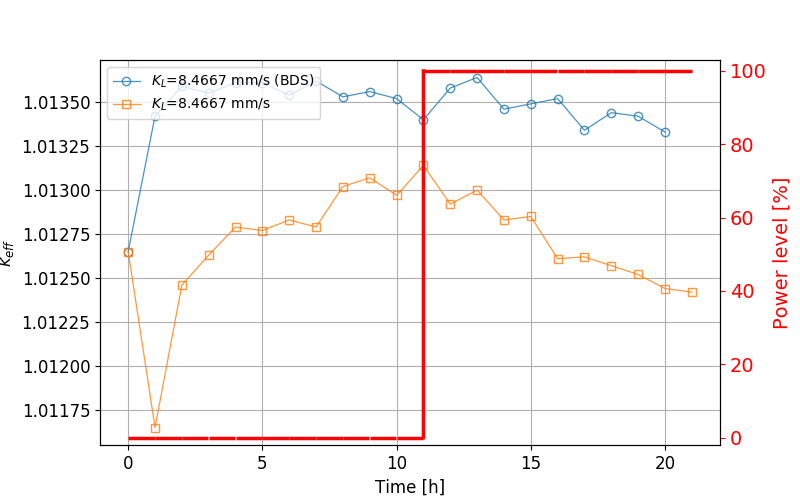

[4.8999996 4.8999996 4.8999996 4.8999996 4.8999996 4.8999996 4.8999996
 4.8999996 4.8999996 5.        4.8999996 5.        4.8999996 4.8999996
 4.8999996 4.8999996 4.8999996 4.8999996 4.8999996 4.8999996 4.8999996]


In [13]:
print(t_eds, power, k_eds)
print (len(t_eds), len(power))
# Initialize figure
fig_keff = matplotlib.pyplot.figure(1, figsize=(8,5))
ax1 = fig_keff.add_subplot(111)
ax1.grid(True)
ax1.plot(t_bds, k_bds, 'o-', label=r'$K_L$=8.4667 mm/s (BDS)', linewidth=0.9, alpha=0.8, markerfacecolor="None")
ax1.plot(t_eds, k_eds, 's-', label=r'$K_L$=8.4667 mm/s', linewidth=0.9, alpha=0.8, markerfacecolor="None")

#ax1.fill_between(t_bds, k_bds-k_bds_err, k_bds+k_bds_err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
#ax1.fill_between(t_eds, k_eds-k_eds_err, k_eds+k_eds_err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)

ax1.legend(loc=2)
ax1.set_ylabel(r'$k_{eff}$', fontsize=12)
ax1.set_xlabel('Time [h]', fontsize=12)
#ax1.set_xlim(0,21)
ax1.tick_params('x', labelsize=12)
# ax1.set_xticks(days_tap)
ax1.tick_params('y', labelsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge', width=0.99, ls="-",
        edgecolor='#fc0303', linewidth=2.5, fill=False)
ax2.plot([11,11.0001],[0, 100], c='red', alpha=1, linewidth=2.5)
ax2.set_ylim(-2,103)
ax2.set_ylabel('Power level [%]', color='r', fontsize=14)
ax2.tick_params('y', colors='r', labelsize=14)


fig_keff.show()
#fig_keff.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/eps/keff_zoomed.png',bbox_inches='tight', dpi=900)
print(1e5*k_bds_err)
#print(100*power/np.amax(power))

<IPython.core.display.Javascript object>


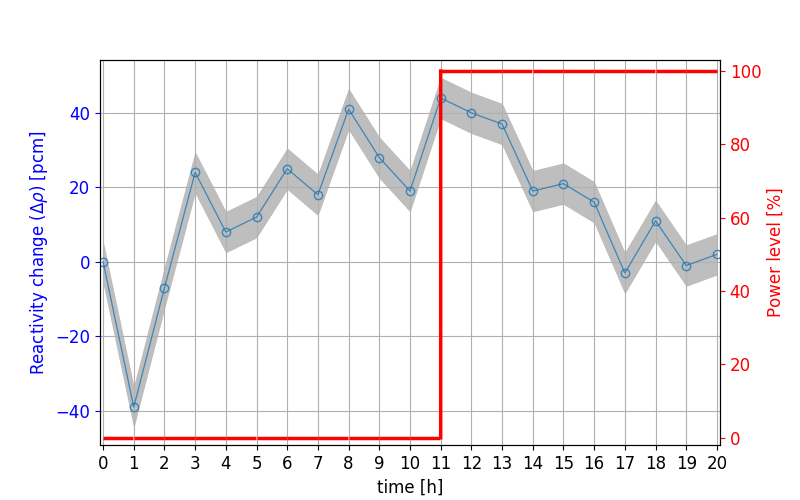

Maximum reactivity drop 0.000000 pcm
Maximum reactivity spike 60.999393 pcm


In [4]:
fig_rho = matplotlib.pyplot.figure(2, figsize=(8,5))
ax1 = fig_rho.add_subplot(111)
ax1.grid(True)
#ax1.plot(t_bds, 1e+5*(k_bds-k_bds[t_indx_shutdown]), 'o-', label=r'$K_L$=8.4667 mm/s (BDS)', linewidth=0.9, alpha=0.8, markerfacecolor="None")
ax1.plot(t_eds, 1e+5*(k_eds-k_eds[t_indx_shutdown]), 'o-', label=r'$K_L$=8.4667 mm/s (BDS)', linewidth=0.9, alpha=0.8, markerfacecolor="None")
#ax1.plot(t_eds, 1e+5*(k_eds-1.0), 's-', label=r'$K_L$=8.4667 mm/s (EDS)', linewidth=1.5, alpha=1, markerfacecolor="None", color='b')

#ax1.fill_between(t_bds, 1e+5*(k_bds-k_bds[t_indx_shutdown]-k_bds_err), 1e+5*(k_bds-k_bds[t_indx_shutdown]+k_eds_err), edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
ax1.fill_between(t_eds, 1e+5*(k_eds-k_eds[t_indx_shutdown]-k_eds_err), 1e+5*(k_eds-k_eds[t_indx_shutdown]+k_eds_err), edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
#ax1.fill_between(t_eds, 1e+5*(k_eds-1.0-k_eds_err), 1e+5*(k_eds-1.+k_eds_err), edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)

#ax1.legend(loc=2)
ax1.set_ylabel(r'Reactivity change ($\Delta\rho$) [pcm]', color='b', fontsize=12)
ax1.set_xlabel('time [h]', fontsize=12)
ax1.set_xlim(-0.1,20.1)
ax1.tick_params('x', labelsize=12)
ax1.set_xticks(t_eds)
ax1.tick_params('y', colors='b',labelsize=12)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge', width=0.99, ls="-",
        edgecolor='#fc0303', linewidth=2.5, fill=False)
ax2.plot([11,11.0001],[0, 100], c='red', alpha=1, linewidth=2.5)
ax2.set_ylim(-2,103)
ax2.set_ylabel('Power level [%]', color='r', fontsize=12)
ax2.tick_params('y', colors='r', labelsize=12)


fig_rho.show()
#fig_rho.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch5/rho_kl100_eol_eoc.png',bbox_inches='tight', dpi=700)
print('Maximum reactivity drop %f pcm' %(np.amin(1e+5*(k_bds-k_bds[t_indx_shutdown]))))
print('Maximum reactivity spike %f pcm' %(np.amax(1e+5*(k_bds-k_bds[t_indx_shutdown]))))

<IPython.core.display.Javascript object>


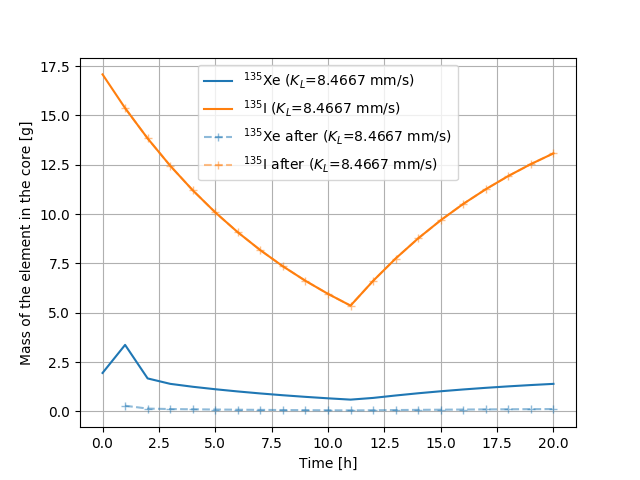

In [5]:
#plot_iso = ['He4']
#plot_iso = ['U235','U238']
plot_iso = ['Xe135', 'I135']
#print(len(t_comp[:3001]), len(t_comp_5))


# Initialize figure
fig_comp = matplotlib.pyplot.figure(3)#, figsize=[7,5])
ax1 = fig_comp.subplots()
ax1.grid(True)

for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax1.plot(t_comp, 1e6*mass_before[i], '-', label=str(k_name)+' ($K_L$=8.4667 mm/s)', linewidth=1.5)
    # ax1.plot(t_comp_50/365.0, mass_before_50[i], '-', label=str(k_name)+' ($K_L$=2.1167 mm/s)', color='g', linewidth=1.5)
    # ax1.plot(t_comp_5/365.0, mass_before_5[i], '-', label=str(k_name)+' ($K_L$=0.0847 mm/s)', color='r', linewidth=1.5)
    
    #ax1.plot(t_comp/365.0, (1-0.9148573428740562)*mass_before[i], '--', 
    #             label='Exp '+str(k_name)+'($K_L$=100 ft/hr)', color='b', linewidth=2.5)
    #ax1.plot(t_comp_5/365.0, (1-0.03103426584056919)*mass_before_5[i], '--',
    #             label='Exp '+str(k_name)+' ($K_L$=1 ft/hr)', color='r', linewidth=2.5)

ax1.set_prop_cycle(color=colors[0:])
for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax1.plot(t_comp[1:], 1e6*mass_after[i], '+--', label=str(k_name)+' after ($K_L$=8.4667 mm/s)', linewidth=1.5, alpha=0.5)
    # ax1.plot(t_comp_50[1:]/365.0, mass_after_50[i], '-.', label=str(k_name)+' after ($K_L$=2.1167 mm/s)', color='g', linewidth=1.5)
    # ax1.plot(t_comp_5[1:]/365.0, mass_after_5[i], '-.', label=str(k_name)+' after ($K_L$=0.0847 mm/s)', color='r', linewidth=1.5)
    

ax1.legend(loc=0)
#ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylabel('Mass of the element in the core [g]')
ax1.set_xlabel('Time [h]')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
#ax1.set_xlim(0, 13)
#ax1.set_ylim(0, 7)
#ax1.set_ylim(2e-, 2.5e-5)

#ax2 = ax1.twinx()
#ax2.set_prop_cycle(color=colors[1:])
#ax2.set_ylabel(r'mass difference between 0.012 and 1% void fraction [%]')
#ax2.set_ylabel(r'relative mass difference [%]', color='red')
#for i in plot_iso:
#    m=next(markers)
#    el_aaa = elem_aaa(i)
#    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
#    ax2.plot(t_comp[:3200]/365.0,
#       100*(mass_before_5[i] - mass_before[i][:3200])/mass_before[i][:3200],
#         '--', color='red') #, label=str(k_name)+" (1% void fraction)")

#ax2.legend(loc=4)
#ax2.set_ylim([-0.90, 0.02])
#ax2.tick_params('y', colors='r')
#ax2.set_ylim([-0.65, 0.02])
#ax2.set_ylim([-1.65, -0.38])

# Zoom 1 (hard spectrum)
#ax1.set_xlim(0, 1.5)
#ax1.set_ylim(0.000021, 0.0000235)

# Zoom 2 (soft)
#ax1.set_xlim(22, 23.5)
#ax1.set_ylim(0.000017, 0.00002)

fig_comp.show()
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/eps/xe135.png',bbox_inches='tight', dpi=700)
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/void/pu239.png',bbox_inches='tight', dpi=700)
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/void/u238.png',bbox_inches='tight', dpi=700)

In [6]:
V = 4.43530000000000E+07 # cm3
NA = 6.02214076e23

N_xe_0 = mass_before['Xe135'][0]
N_i_0 = mass_before['I135'][0]
N_te_0 = mass_before['Te135'][0]


lamb_xe = data.decay_const('Xe-135')
lamb_i = data.decay_const('I-135')
lamb_te = data.decay_const('Te-135')
10
nom = lamb_xe*(lamb_i*(N_xe_0+N_i_0)-lamb_xe*N_xe_0)
den = lamb_i**2 * N_i_0
t_peak = np.log(nom/den) / (lamb_xe-lamb_i)

print("Operative excees reactivity %f pcm" %(1e5*(k_eds[0]-1.0)))
print('Analytical solution for the Xe-135 peak %f s, %f h' %(t_peak, t_peak/3600))
print('I135/Xe135 ratio at the beginning of the transient %f' 
        %(N_i_0/N_xe_0))
print('Xe135 concentration peak %f [%%]' %(100*np.amax(mass_before['Xe135'])/N_xe_0))
print('Maximum reactivity change after shutdown %f pcm ' %(1e5*np.amin((k_eds-k_eds[t_indx_shutdown]))))

Operative excees reactivity 1936.995983 pcm
Analytical solution for the Xe-135 peak 36258.361329 s, 10.071767 h
I135/Xe135 ratio at the beginning of the transient 8.763744
Xe135 concentration peak 172.950685 [%]
Maximum reactivity change after shutdown -38.993359 pcm 
